In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

#load in training data on each potential synapse
data = pd.read_csv("../Data/train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("../Data/feature_weights.csv")
morph_embeddings = pd.read_csv("../Data/morph_embeddings.csv")


In [3]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [4]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

##  Feature Engineering

### feature weight similarity

In [6]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [7]:
# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)

### projection group direction

In [8]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

## Model Training

In [18]:
## REPLACE WITH GRACE's FUNCTION LATER
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148665 entries, 135011 to 128037
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              148665 non-null  int64  
 1   axonal_coor_x                   148665 non-null  int64  
 2   axonal_coor_y                   148665 non-null  int64  
 3   axonal_coor_z                   148665 non-null  int64  
 4   dendritic_coor_x                148665 non-null  int64  
 5   dendritic_coor_y                148665 non-null  int64  
 6   dendritic_coor_z                148665 non-null  int64  
 7   adp_dist                        148665 non-null  float64
 8   post_skeletal_distance_to_soma  148665 non-null  float64
 9   pre_skeletal_distance_to_soma   148665 non-null  float64
 10  pre_oracle                      148665 non-null  float64
 11  pre_test_score                  148665 non-null  float64
 12  pre_rf_x        

In [30]:
X = train_data[["fw_similarity", "adp_dist", "pre_oracle", "pre_test_score", "post_oracle", "post_test_score", "pre_skeletal_distance_to_soma", "post_skeletal_distance_to_soma"]]
y = train_data["connected"]

In [31]:
from imblearn.over_sampling import RandomOverSampler

# oversample connected neuron pairs
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    X, y
)

Attempting to perform ANOVA for feature selection --> kernel svm --> prediction

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [49]:
pipe = Pipeline( [
    ("anova", SelectPercentile(f_classif)),
    ("scaler", StandardScaler()), #standarization
    ("model", LinearDiscriminantAnalysis())]
)

In [ ]:
#Taking too long to run >5min
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
    'svc__gamma': [0.1, 1, 10, 100]
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_resampled, y_resampled)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

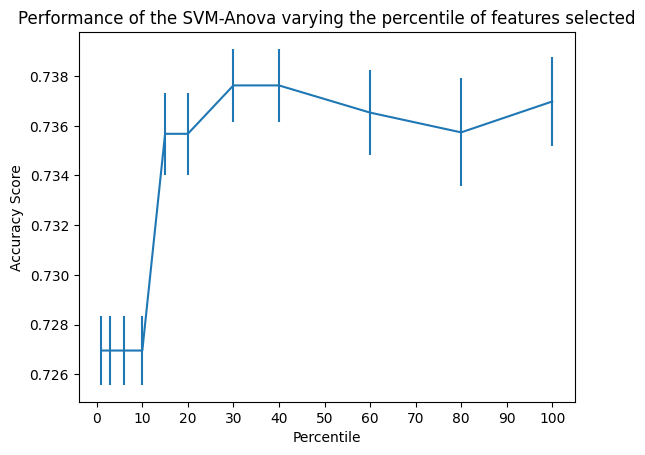

In [50]:
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    pipe.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(pipe, X_resampled, y_resampled)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

In [35]:
LogisticRegression(random_state=2, solver = 'saga').fit(X)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=2, solver='saga'))])

In [ ]:
pipe = Pipeline(
    [
        ("scaling", StandardScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC(dual=False, max_iter=10000)),
    ]
)

In [12]:


# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"]])[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

# confusion matrix
print(confusion_matrix(test_data['connected'], test_data['pred'] > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

accuracy: 0.647752038098313
[[23859 13037]
 [   55   216]]
balanced accuracy: 0.7218517172433216


Submission Prediction

In [14]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("../Data/leaderboard_data.csv")
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)

In [15]:
# oversample connected neuron pairs for full training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    data[["fw_similarity", "adp_dist"]], data["connected"]
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on leaderboard data
lb_data["pred"] = pipe.predict_proba(lb_data[["fw_similarity", "adp_dist"]])[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

In [16]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [17]:
#writing csv files
submission_data.to_csv('example_submission_data.csv',index=False)